In [2]:
import os, pickle, time, glob, sys, copy
import numpy as np 
import scipy
import mdtraj as md 
import MDAnalysis as mda
#import nglview as nv 
from ipywidgets import interactive, VBox
import sklearn.preprocessing as pre
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import pyemma as py 
from pyemma.util.contexts import settings
import warnings
import seaborn as sns
from scipy.stats import pearsonr as pears
warnings.filterwarnings('ignore')

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'   # only see the more powerful GPU

import tensorflow as tf
import keras.backend as K
from keras.models import load_model
from keras.callbacks import EarlyStopping
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.tensorflow_backend.set_session(tf.Session(config=config))

# check for gpu usage
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print(sess)

import sys
from hde import hde, molgen
from utils import * 

# for calculating KL divergence between distributions
from scipy.stats import entropy

# import local propogator function to test clipping
sys.path.append("./hde/")

from propagator_org import *  #import get_multi_mixture_loss_func
from propagator_dof import *


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



Using TensorFlow backend.


In [3]:
class MULTI_LSS():
    ''' Train a LSS pipeline for bi-molecular system 
        Includes methods for training, testing, and analysis of each LSS step
        Attributes/methods are accesible for external analysis

        Parameters
        ----------
        feats_list : list of npy file of 2 or 3 dims
            trajectories x frames x features
            
    '''
    
    def __init__(self, feats_list, n_atoms=64, n_components=2):
        
        self.n_atoms = n_atoms
        
        # system with 2 components should have three features sets
        if n_components==2:
            assert len(feats_list) == 4
            
            #### less confusing to just give these each an invidual input
            self.ds_feats = np.float32(feats_list[0])
            self.s1_feats = np.float32(feats_list[1])
            self.s2_feats = np.float32(feats_list[2])
            self.pros_feats = np.float32(feats_list[3])
            
            # Should be able to get rid of these with correct implementation
            self.SRV_ds = None
            self.SRV_s1 = None
            self.SRV_s2 = None
            self.prop = None
            self.prof_dof = None
            self.traj_prop_scaled = None
            
            self.molgen_ds = None
            self.molgen_s1 = None
            self.molgen_s2 = None
            
            self.all_xyz_scaled = None
            self.train_test_ds = None
            self.train_test_s1 = None
            self.train_test_s2 = None
            
    
    def fit_SRV(traj_list, dim, max_epochs, lag, verbose=True,
            batch_size=50000, lrate=0.01, val_split=0.0001):
        '''instantiate and fit SRV object, return the object'''

        SRV = HDE(
            np.shape(traj_list)[-1], 
            n_components=dim, 
            validation_split=val_split, 
            n_epochs=max_epochs, 
            lag_time=lag, 
            batch_size=batch_size, #500000
            #callbacks=calls,  # comment out for consistet training time
            learning_rate=lrate, 
            batch_normalization=True,
            latent_space_noise=0.0,
            verbose=verbose
        )

        SRV = SRV.fit(traj_list)
        return SRV
    
    def fit_SRVs(self, dim_list, max_epochs, lag, feat_range=None):
        '''Fit each SRV independently, should allow inputs to be list or ints'''
        
        # number of dims used to construct each SRV
        [self.ds_dim, self.s1_dim, self.s2_dim] = dim_list
        
        # if not feat range is specified
        if feat_range is None:
            self.SRV_ds = fit_SRV([d for d in self.ds_feats], self.ds_dim, max_epochs, lag)
            self.SRV_s1 = fit_SRV([d for d in self.s1_feats], self.s1_dim, max_epochs, lag)
            self.SRV_s2 = fit_SRV([d for d in self.s2_feats], self.s2_dim, max_epochs, lag)

        # scale each input by feat_range and save scaler objects for later
        else:
            self.feat_scaler_ds = pre.MinMaxScaler(feature_range=feat_range).fit(np.concatenate(self.ds_feats))
            self.SRV_ds = fit_SRV([self.feat_scaler_ds.transform(d) for d in self.ds_feats], self.ds_dim, max_epochs, lag)
        
            self.feat_scaler_s1 = pre.MinMaxScaler(feature_range=feat_range).fit(np.concatenate(self.s1_feats))
            self.SRV_s1 = fit_SRV([self.feat_scaler_s1.transform(d) for d in self.s1_feats], self.s1_dim, max_epochs, lag)
        
            self.feat_scaler_s2 = pre.MinMaxScaler(feature_range=feat_range).fit(np.concatenate(self.s2_feats))
            self.SRV_s2 = fit_SRV([self.feat_scaler_s2.transform(d) for d in self.s2_feats], self.s2_dim, max_epochs, lag)
        
    def srv_correlations(self, ds_modes=[0,1], s1_modes=[0,1], s2_modes=[0,1], pros_modes=[], smooth=True):
        '''check for correlations between leading modes of independent srvs'''

        prop_names = ['ds', 's1', 's2', 'pros']
        prop_modes = [ds_modes, s1_modes, s2_modes, pros_modes]
        self.combine_SRV_outputs(prop_modes, smooth=smooth)

        # setup correlation analysis
        traj_prop_c = np.concatenate(self.traj_prop_scaled)
        total_modes = traj_prop_c.shape[-1]
        pears_arr, mask = np.zeros((total_modes, total_modes)), np.zeros((total_modes, total_modes))

        # find pearson correlations between all modes
        for i in range(total_modes):
            for j in range(total_modes):
                pears_arr[i, j], _ = np.abs(pears(traj_prop_c[:, i], traj_prop_c[:, j]))
                if i <= j: mask[i, j] = 1

        # label axes
        label_list = []
        for modes, name in zip(prop_modes, prop_names):
            for i, mode in enumerate(modes):
                label_list.append(f'{name} mode-{i+1}')

        # plot heatmap
        fig, ax = plt.subplots(figsize=(6, 5))
        sns.heatmap(pears_arr, ax=ax, mask=mask, vmin=0, vmax=1, cmap='viridis', 
                   xticklabels=label_list, yticklabels=label_list)
        
    def save_SRVs(self, save_path):
        '''save all trained SRVs as a list'''
        
        pickle.dump([self.SRV_ds, self.SRV_s1, self.SRV_s2, self.feat_scaler_ds, self.feat_scaler_s1, self.feat_scaler_s2], open(save_path, 'wb'))
        
    def load_SRVs(self, load_path):
        '''load pre-trained SRVs to skip fitting step'''
        
        [self.SRV_ds, self.SRV_s1, self.SRV_s2, self.feat_scaler_ds, self.feat_scaler_s1, self.feat_scaler_s2] = pickle.load(open(load_path, 'rb'))

    def combine_SRV_outputs(self, prop_modes, smooth=False, feat_range=(0, 1), pros_transform=None):
        '''Combine desired SRV modes + orientation information
           Output will be used for propogator and molgen '''
        
        # make sure SRV modes exist
        if self.SRV_ds is None:
            raise ValueError('SRVs must be fit first')
            
        self.ds_modes, self.s1_modes, self.s2_modes, self.pros_modes = prop_modes
        
        # transform and combine each set of coordinates
        traj_prop = []
        for ds_feat, s1_feat, s2_feat, pros_feat in zip(
            self.ds_feats, self.s1_feats, self.s2_feats, self.pros_feats):
            ds_coords = self.SRV_ds.transform(self.feat_scaler_ds.transform(ds_feat))[:, self.ds_modes]
            s1_coords = self.SRV_s1.transform(self.feat_scaler_s1.transform(s1_feat))[:, self.s1_modes]
            s2_coords = self.SRV_s2.transform(self.feat_scaler_s2.transform(s2_feat))[:, self.s2_modes]
            pros_coords = pros_feat[:, self.pros_modes]
            
            traj_prop.append(np.concatenate([ds_coords, s1_coords, s2_coords, pros_coords], axis=1))
            
        # scale to 0,1 for compatibility with the propogator
        self.prop_scaler = pre.MinMaxScaler(feature_range=feat_range)
        self.prop_scaler.fit(np.concatenate(traj_prop))
        self.traj_prop_scaled = [self.prop_scaler.transform(traj) for traj in traj_prop]
        print(np.shape(self.traj_prop_scaled))
    
    def fit_prop(self, prop_modes=None, n_trajs=None, n_mix=25, lag=10, lr=0.0001, smooth=False,
                 n_epochs=100, patience=50, batch=2000, hidden_size=100, feat_range=(0, 1), 
                 pros_transform=None, activation='relu', fit=True):
        '''Determine which SRV modes should be propogated and fit propogator'''
        
        if self.SRV_ds is None:
            raise ValueError('Fit SRVs first')
            
        self.prop_modes = prop_modes
        self.lag_prop = lag
        self.lr_prop = lr
        self.batch_prop = batch
        self.n_epochs_prop = n_epochs
        self.n_trajs = n_trajs
        self.n_mix = n_mix
        self.hidden_prop = hidden_size
        self.act_prop = activation
        
        # combine and scale srv outputs
        self.combine_SRV_outputs(self.prop_modes, smooth=smooth, feat_range=feat_range, 
                                 pros_transform=pros_transform)

        # can turn off by setting patience > n_epoch
        self.callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor='loss', patience=patience, restore_best_weights=True),
            tf.keras.callbacks.History()
        ]
        
        print('Shape of traj_prop: ', np.shape(self.traj_prop_scaled))
        
        #instantiate and compile prop
        self.prop = Propagator(
                self.traj_prop_scaled[0].shape[-1], 
                n_components=n_mix, 
                lag_time=lag, 
                batch_size=batch, 
                learning_rate=lr, 
                n_epochs=n_epochs,
                callbacks=self.callbacks,
                hidden_size=hidden_size,
                activation=activation,
            )
        
        # fit prop, or reload
        if fit:
            
            # reduce input_dim by 1 to avoid predicting the temp dim
            self.prop.model.compile(loss=get_mixture_loss_func(self.prop.input_dim, 
                                                        self.prop.n_components), 
                               optimizer=tf.keras.optimizers.Adam(lr=lr))
        
            print('Starting fit')
            self.prop.fit(self.traj_prop_scaled)
        
    def fit_prop_dof(self, fit=True, dist_dim=3, angle_dim=3, dof_epochs=10):
        '''Same as above, but for dists and angles'''
        
        # make Prop_dof more generatle -- can take any input /output size
        self.dist_dim, self.angle_dim = dist_dim, angle_dim
        
        # recombine SRV modes to include DoF
        prop_modes = self.prop_modes[:-1] 
        prop_modes.append(list(np.arange(dist_dim)))
        self.combine_SRV_outputs(prop_modes=prop_modes)

        # train prop for dof using both srv and dof as input
        self.prop_dists = Propagator_dof(
                input_dim = self.traj_prop_scaled[0].shape[-1], 
                dof_dim = dist_dim,
                n_components=self.n_mix, 
                lag_time=self.lag_prop, 
                batch_size=self.batch_prop, 
                learning_rate=self.lr_prop, 
                n_epochs=dof_epochs,  #self.n_epochs_prop,
                callbacks=self.callbacks,
                hidden_size=self.hidden_prop,
                activation=self.act_prop,  
            )

        # reduce input_dim by 1 to avoid predicting the temp dim
        lss.prop_dists.model.compile(loss=get_mixture_loss_func(dist_dim, 
                                     self.prop_dists.n_components), 
                                     optimizer=tf.keras.optimizers.Adam(lr=self.lr_prop))
        
        if fit:
            lss.prop_dists.fit(self.traj_prop_scaled)
        
        # recombine SRV modes to include DoF
        prop_modes = self.prop_modes[:-1] 
        prop_modes.append(list(np.arange(dist_dim + angle_dim)))
        self.combine_SRV_outputs(prop_modes=prop_modes)

        # train prop for dof using both srv and dof as input
        self.prop_angles = Propagator_dof(
                input_dim = self.traj_prop_scaled[0].shape[-1], 
                dof_dim = angle_dim,
                n_components=self.n_mix, 
                lag_time=self.lag_prop, 
                batch_size=self.batch_prop, 
                learning_rate=self.lr_prop, 
                n_epochs=dof_epochs,  #self.n_epochs_prop,
                callbacks=self.callbacks,
                hidden_size=self.hidden_prop,
                activation=self.act_prop,  
            )

        # reduce input_dim by 1 to avoid predicting the temp dim
        lss.prop_angles.model.compile(loss=get_mixture_loss_func(angle_dim, 
                                     self.prop_dists.n_components), 
                                     optimizer=tf.keras.optimizers.Adam(lr=self.lr_prop))
        
        if fit:
            lss.prop_angles.fit(self.traj_prop_scaled)
        
        
    def gen_prop(self, n_trajs=1, n_steps=None, traj_init=0):
        '''Generater synthetic SRV using sequential props'''
        
        n_dofs = self.dist_dim + self.angle_dim

        # default n_steps should be length of training / lag
        if n_steps is None:
            n_steps = len(lss.traj_prop_scaled[0])//lss.lag_prop
            
        synth_trajs = []    
        for i in range(n_trajs):
            
            # start each from unique index
            if isinstance(traj_init, list): traj_idx = traj_init[i]
            else: traj_idx = traj_init
    
            # get initial coordinates for srv prop
            x0_srv = lss.traj_prop_scaled[traj_idx][0, :-n_dofs].reshape(1,-1)
            
            # propogate srv modes only first
            xp_srv = lss.prop.propagate(x0_srv, n_steps).reshape(n_steps, -1)
            x1_srv = xp_srv[1].reshape(1,-1)

            # concatenate init dof with init srv
            x0_dist = lss.traj_prop_scaled[traj_idx][0, -n_dofs:-self.angle_dim].reshape(1,-1)
            x0_dist = np.concatenate([x0_dist, x1_srv], axis=1)

            # propogate dists
            xp_dist = lss.prop_dists.propagate(x0_dist, xp_srv, n_steps).reshape(n_steps, -1)[:, :self.dist_dim]
            
            # combine with srv
            xp_srv_dist = np.concatenate([xp_srv, xp_dist], axis=1)
            x1_srv_dist = xp_srv_dist[1].reshape(1,-1)
            
            # get angle inits
            x0_angle = lss.traj_prop_scaled[traj_idx][0, -self.angle_dim:].reshape(1,-1)
            x0_angle = np.concatenate([x0_angle, x1_srv_dist], axis=1)

            # propogate angles
            xp_angle = lss.prop_angles.propagate(x0_angle, xp_srv_dist, n_steps).reshape(n_steps, -1)[:, :self.angle_dim]
            
            # concatenate with xp_srv and append to list of synth_trajs
            xp = np.concatenate([xp_srv_dist, xp_angle], axis=1)
            synth_trajs.append(xp)
            print(np.shape(synth_trajs))
            
        return synth_trajs

    def check_prop_kinetics(self, traj_idx=0):
        '''check kinetic behavior of prop for one traj and compare to reference
           Specify traj_idx to compare against the kinetics and initial conditions of a particular traj'''
        
        if self.prop is None:
            raise ValueError('Prop must be fit first')
        
        # plot loss over epochs
        fig, axes = plt.subplots(1, 3, figsize=(12, 3))
        try:
            axes[0].plot(self.prop.model.history.history['loss'], label='loss')
            axes[0].set_title('Training Loss')
            axes[0].set_xlabel('Epochs')
        except:
            pass
        
        # plot real (training) modes for each traj
        total_modes = np.shape(self.traj_prop_scaled)[-1]
        for i in range(total_modes):
            axes[1].plot(2*i + self.traj_prop_scaled[traj_idx][::self.lag_prop, i], label=f'mode = {i+1}')
            
        # plot synth (propogated) modes for each traj
        synth_traj_scaled = self.gen_prop(n_trajs=1, traj_init=traj_idx)[0]
        for i in range(total_modes):
            axes[2].plot(2*i + synth_traj_scaled[:, i], label=f'mode = {i+1}')  
        
        axes[0].set_title(f'lag-{self.lag_prop} batch-{self.batch_prop} epochs-{self.n_epochs_prop}')
        axes[1].set_title('Reference')
        axes[2].set_title('Synthetic')
        
        return synth_traj_scaled
            
    def check_prop_thermo(self):
        '''check long-time thermo behavior of prop and compare to reference'''
        
        if self.prop is None:
            raise ValueError('Prop must be fit first')

        # plot real (training) modes for each traj
        [n_trajs, traj_length, total_modes] = np.shape(self.traj_prop_scaled)
        traj_prop_init = self.traj_prop_scaled[0][0]
        
        # plot loss over epochs
        fig, axes = plt.subplots(2, total_modes, figsize=(3*total_modes, 6), sharey=False)
        
        # make synth traj for length of the conc training data
        n_steps = n_trajs*traj_length//self.lag_prop
        synth_traj_scaled = gen_prop(self, n_trajs=1, n_steps=n_steps, traj_init=traj_idx)[0]
        
        # plot distributions of each mode
        for i, axr in enumerate(axes.T):
            for ax in axr:
                sns.set_style('whitegrid')
                sns.distplot(synth_traj_scaled[:, i], label="LSS", ax=ax)
                sns.distplot(np.concatenate(self.traj_prop_scaled)[::self.lag_prop, i], 
                             label="Reference", ax=ax)
                #ax.set_title(f'Mode {i}')
                #ax.set_xlabel("SRV coords")
                ax.set_ylabel("")
            axr[1].set_yscale('log')
            
        axes[0, 0].legend(fontsize=16)
        plt.subplots_adjust(hspace=0.45)
        ax.legend()
        
        return synth_traj_scaled
            
        
    def fit_molgen(self, xyz_scaled, srv_idxs, interact_idxs=None):
        '''Train molgen to backmap trajectory given low dim inputs
           Use all available modes for reconstruction -- no distance or orientation information'''
        
        # subsample srv based on specific inputs
        srv_scaled = self.srvs_mg_scaled[:, srv_idxs]
        
        # break into train and test sets
        xyz_test = xyz_scaled[:self.n_test_molgen]
        srv_test = srv_scaled[:self.n_test_molgen]
        
        # only include interacting frames in training -- test on everything
        if interact_idxs is None:
            xyz_train = xyz_scaled[self.n_test_molgen:]
            srv_train = srv_scaled[self.n_test_molgen:]
        else:
            xyz_train = xyz_scaled[self.n_test_molgen:][interact_idxs]
            srv_train = srv_scaled[self.n_test_molgen:][interact_idxs]
            
        train_test = [srv_train, xyz_train, srv_test, xyz_test]
        del xyz_scaled, srv_scaled

        # instantiate cWGAN TODO: play with cWGAN hyperparams (noise_dim, hidden_size) for better reconstruction
        molgen = MolGen(
            latent_dim=np.shape(srv_train)[1],
            output_dim=np.shape(xyz_train)[1],
            batch_size=self.batch_molgen, #30000
            noise_dim=self.noise_dim,
            n_epochs=self.n_epochs_molgen, #2500
            hidden_layer_depth=2,
            hidden_size=self.hidden_size,
            n_discriminator=self.n_discriminator,
            verbose=False
        )
        
        # fit molgen
        molgen.fit(srv_train, xyz_train)
        
        return molgen, train_test
    
    def fit_molgens(self, all_xyzs, all_xyz_scalers, srv_range=(-1, 1), batch=1000, n_epochs=5000, 
                    stride=10, n_test=20000, interact_idxs=None, noise_dim=50, n_discriminator=5, hidden_size=200):
        '''Fit both the ds molgen ss molgens, use proscrutes to combine the ss'''
        
        if self.SRV_ds is None:
            raise ValueError('SRVs must be fit first')
            
        if self.traj_prop_scaled is None:
            raise ValueError('prop must be fit or combine_SRV_outputs first')
        
        # need scaler information later on
        self.stride_molgen = stride
        self.n_test_molgen = n_test
        self.batch_molgen = batch
        self.n_epochs_molgen = n_epochs
        self.noise_dim = noise_dim
        self.n_discriminator = n_discriminator
        self.hidden_size = hidden_size
        
        [self.xyz_scaler_ds, self.xyz_scaler_s1, self.xyz_scaler_s2] = all_xyz_scalers
        
        # extract xyz and topology lists
        xyz_ds, xyz_s1, xyz_s2 = all_xyzs
          
        # specify which srv coords are passed into which molgen -- can make this tunable
        ds_idxs = self.ds_modes
        s1_idxs = list(len(ds_idxs) + np.array(self.s1_modes))
        s2_idxs = list(len(ds_idxs)+len(s1_idxs) + np.array(self.s2_modes))
        self.srv_ds_idxs = ds_idxs + s1_idxs + s2_idxs
        self.srv_s1_idxs = ds_idxs + s1_idxs
        self.srv_s2_idxs = ds_idxs + s2_idxs
        print(self.srv_ds_idxs, self.srv_s1_idxs, self.srv_s2_idxs)
        
        # scale all srvs to specified norm -- works best at -1,1
        srvs_mg = np.concatenate([t[::self.stride_molgen, self.srv_ds_idxs] for t in self.traj_prop_scaled])
        self.srvs_mg_scaler = pre.MinMaxScaler(feature_range=srv_range).fit(srvs_mg)
        self.srvs_mg_scaled = self.srvs_mg_scaler.transform(srvs_mg)
        
        # can just add smoothening step here if we do not care about it being included in the prop?
        
        # fit the combined molgen on all available srv modes -- only train on interacting
        self.molgen_ds, self.train_test_ds = self.fit_molgen(xyz_ds, srv_idxs=self.srv_ds_idxs, interact_idxs = interact_idxs)
        
        # fit s1 molgen
        self.molgen_s1, self.train_test_s1 = self.fit_molgen(xyz_s1, srv_idxs=self.srv_s1_idxs)
        
        # fit s2 molgen
        self.molgen_s2, self.train_test_s2 = self.fit_molgen(xyz_s2, srv_idxs=self.srv_s2_idxs)
        
    def test_molgen(self, save_traj_name, component ='ds', traj_type='real',
                       save_traj_dir='./trajs/molgen-only_trajs/', ref_name='reference'):
        ''' Generate a trajectory from srv test set and save it to save_traj'''
                
        # specify which type of reconstruction
        if component=='ds':
            srv_test, xyz_test = self.train_test_ds[-2:]
            molgen = self.molgen_ds
            xyz_scaler = self.xyz_scaler_ds
            n_atoms = self.n_atoms
        elif component=='s1':
            srv_test, xyz_test = self.train_test_s1[-2:]
            molgen = self.molgen_s1
            xyz_scaler = self.xyz_scaler_s1
            n_atoms = self.n_atoms//2   # this should be specific to each component
        elif component=='s2':
            srv_test, xyz_test = self.train_test_s2[-2:]
            molgen = self.molgen_s2
            xyz_scaler = self.xyz_scaler_s2
            n_atoms = self.n_atoms//2
        
        # generate molgen traj form srv_test data
        xyz_gen = molgen.transform(srv_test)        # save each generated trajs for analysis and recombination
        
        # reshape and save gen traj
        xyz_gen_reshaped = xyz_scaler.inverse_transform(xyz_gen).reshape(-1, n_atoms, 3)
        save_new_xyz(save_traj_name, save_traj_dir, xyz_gen_reshaped)
        
        # save a reference at the same stride
        xyz_test_reshaped = xyz_scaler.inverse_transform(xyz_test).reshape(-1, n_atoms, 3)
        save_new_xyz(f'{ref_name}_{component}', save_traj_dir, xyz_test_reshaped)
        
        # save each generated trajs for analysis and recombination
        if component=='ds': self.xyz_gen_ds = xyz_gen_reshaped
        elif component=='s1': self.xyz_gen_s1 = xyz_gen_reshaped
        elif component=='s2': self.xyz_gen_s2 = xyz_gen_reshaped
            
        return xyz_test_reshaped
        
    
    def combine_molgens_s1_s2(self, save_traj_name=None, save_traj_dir='./trajs/molgen-only_trajs/', 
                             s1_traj=None, s2_traj=None, pros_traj=None):
        '''Take in s1 generated traj, s2 generated traj, and proscrutes transformations
           If not trajs are passed in, will combined training data instead
           TODO: use keyword to specify whether to use training, prop, or input data
           '''
        
        # can be loaded from other sources as well
        if s1_traj is None: s1_traj = self.xyz_gen_s1
        if s2_traj is None: s2_traj = self.xyz_gen_s2
        if pros_traj is None:
            
            # match proscrutes with stride and size of test set
            pros_traj = np.concatenate([p[::self.stride_molgen] for p in self.pros_feats])[:self.n_test_molgen]
        
        # operate on s2 only and keep s1 fixed in place
        s2_pros_traj = []
        for xyz, pros in zip(s2_traj, pros_traj):
            xyz_pros = apply_com_pros(xyz, pros)
            s2_pros_traj.append(xyz_pros)
            
        # combine to make a duplex traj
        s2_pros_traj = np.array(s2_pros_traj)
        comb_traj = np.concatenate((s1_traj, s2_pros_traj), axis=1)
        
        # save as new traj
        if save_traj_name is not None:
            save_new_xyz(save_traj_name, save_traj_dir, comb_traj)
            
        self.xyz_comb = comb_traj
        return comb_traj
    
    def mix_global_and_comb(self, xyz_full=None, xyz_comb=None, pros_traj=None, 
                            r_cutoff=1.0, save_traj_name=None, save_traj_dir='./trajs/molgen-only_trajs/'):
        '''Transform and scale synth traj given molgen and scaler
           prop_molgen_scaler accounts for difference between scalings'''
        
        # account for trainiing and prop -- replace this with a keyword
        if xyz_full is None: xyz_full = self.xyz_gen_ds
        if xyz_comb is None: xyz_comb = self.xyz_comb
        if pros_traj is None: pros_traj = np.concatenate([p[::self.stride_molgen] for p in self.pros_feats])[:self.n_test_molgen]

        pros_xyz = pros_traj[:, :3]
        pros_r = np.sqrt(((pros_xyz)**2).sum(axis=1))
        hbr_idxs = np.where(pros_r < r_cutoff)[0]

        mix_traj = []
        for i in range(len(pros_r)):
            if i in hbr_idxs:  mix_traj.append(xyz_full[i])
            else: mix_traj.append(xyz_comb[i])
        mix_traj = np.array(mix_traj)
                
        # save as new traj
        if save_traj_name is not None:
            save_new_xyz(save_traj_name, save_traj_dir, mix_traj)

        return mix_traj
    
    def molgen_transform(self, molgen, xyz_scaler, synth_traj):
        '''Transform and scale synth traj given molgen and scaler'''

        xyz_gen = molgen.transform(synth_traj)
        n_atoms = xyz_gen.shape[-1]//3
        xyz_gen = xyz_scaler.inverse_transform(xyz_gen).reshape(-1, n_atoms, 3)
        
        return xyz_gen 
    
    
    def generate_synthetic(self, save_traj, n_trajs, n_steps=None,
                           traj_idx=0, r_cutoff=1.0):
        '''Produce a synthetic molgen traj given trained props

        Parameters:

        cutoff: sets where the cutoff boundary will be between full and recomb'''
    
        self.synth_list = []
        self.xyz_synth_full = []
        self.xyz_synth_recomb = []
        n_pros = np.shape(self.pros_feats)[-1]
        
        # create a traj is does not exit
        try: os.mkdir(save_traj)
        except: pass
        
        ## generate indepedent trajs from same or distint starting points (init)
        #for i in range(n_trajs):
        #   synth_traj = self.gen_prop(n_trajs=1, n_steps=n_steps, traj_init=0)[0]
            
        # produces trajs from both hbr and dis inits
        synth_trajs = self.gen_prop(n_trajs=n_trajs, n_steps=n_steps, traj_init=traj_idx)
        print('synth_trajs:', np.shape(synth_trajs))
        
        for i, synth_traj in enumerate(synth_trajs):
            
            # seperate srvs and scale to mg input
            synth_srvs = self.srvs_mg_scaler.transform(synth_traj[:, :-n_pros]) 
            
            # seperate pros features -- inverse transform out of 0,1
            synth_pros = self.prop_scaler.inverse_transform(synth_traj)[:, -n_pros:]
            
            # generate molgen traj from srv_test data
            xyz_gen_full = self.molgen_transform(self.molgen_ds, self.xyz_scaler_ds, synth_srvs[:, self.srv_ds_idxs])
            xyz_gen_s1 = self.molgen_transform(self.molgen_s1, self.xyz_scaler_s1, synth_srvs[:, self.srv_s1_idxs])
            xyz_gen_s2 = self.molgen_transform(self.molgen_s2, self.xyz_scaler_s2, synth_srvs[:, self.srv_s2_idxs])
            
            # combine s1 + s2
            xyz_gen_comb = self.combine_molgens_s1_s2(s1_traj=xyz_gen_s1, s2_traj=xyz_gen_s2, 
                                                       pros_traj=synth_pros, save_traj_name=f'comb_{i}', 
                                                       save_traj_dir=save_traj)
            
            # mix global and combined moel
            xyz_gen_mix = self.mix_global_and_comb(xyz_full=xyz_gen_full, xyz_comb=xyz_gen_comb, 
                                                        pros_traj=synth_pros, r_cutoff=r_cutoff, 
                                                        save_traj_name=f'mix_{i}', save_traj_dir=save_traj)
        return synth_trajs
    
    def check_molgen(self):
        '''Evaluate molgen with rmsd comparison between real and generated test xyz'''
        
        if self.molgen_ds is None:
            raise ValueError('Molgen must be fit first')
            
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        
        # specify whcih type of reconstruction
        if component=='ds':
            srv_train, xyz_test, srv_test, xyz_test = self.train_test_ds
            molgen = self.molgen_ds
        elif component=='s1':
            srv_train, xyz_test, srv_test, xyz_test = self.train_test_s1
            molgen = self.molgen_s1
        elif component=='s2':
            srv_train, xyz_test, srv_test, xyz_test = self.train_test_s2
            molgen = self.molgen_s2
        
        # compare test data with same-sized section of train data
        srv_train, xyz_test, srv_test, xyz_test = self.train_test_ds
        xyz_gen_train = molgen.transform(srv_train[:self.n_test])
        rmsd_test = np.sqrt(np.mean((self.xyz_gen - xyz_test)*2, axis=1))
        rmsd_train = np.sqrt(np.mean((xyz_gen_train - self.xyz_train[:self.n_test])*2, axis=1)) 
         
        # plot as as trajectories and histograms
        pstr = 1
        xis = np.arange(self.n_test)[::pstr] 
        axes[0].plot(rmsd_test[::pstr], alpha=0.8, label='Test')
        axes[0].plot(rmsd_train[::pstr], alpha=0.8, label='Train')
        axes[1].hist(rmsd_test, bins=20, alpha=0.4, label ='Train')
        axes[1].hist(rmsd_train, bins=20, alpha=0.4, label ='Test')
        
        axes[0].legend() 
        axes[1].legend()
        axes[0].set_xlabel('Simulation Time')
        axes[1].set_xlabel('RMSD')
        axes[0].set_ylabel('RMSD')
        axes[1].set_ylabel('Counts')
        axes[0].set_title('RMSD over time')
        axes[1].set_title('RMSD histogram')
    

    def save_pipeline(save_name, save_dir='./save_LSS_components/pipelines/'):
        '''Save each component as a dictionary item for testing'''
        
        save_path = f'{save_dir}{save_name}'
        save_dict = {}
        
        save_dict['srv_list'] = [self.SRV_ds, self.SRV_s1, self.SRV_s2]
        save_dict['prop'] = self.prop
        save_dict['xyz_scaler_list'] = []
        save_dict['molgen_list'] = []
            
        pickle.dump(save_dict, open(save_path, 'wb'))
        
    def load_pipeline(save_name, save_dir='./save_LSS_components/pipelines/'):
        '''Save each component as a dictionary item for testing'''
        
        save_path = f'{save_dir}{save_name}'
        save_dict = pickle.dump(save_dict, open(save_path, 'rb'))

In [4]:
# load inter/intra molecular distance features and instantiate object

# load xyz features for the molgnen
xyz_dict = pickle.load(open('./dists/xyz_dict.pkl', 'rb'))
all_tops = xyz_dict['tops']
all_xyzs = xyz_dict['xyzs']
all_xyz_scalers = xyz_dict['scalers']
print(len(all_xyzs), np.shape(all_xyzs[0]))
del xyz_dict

# load pre-trained SRVs for each system
dim_list, srv_epochs, lag = [3, 3, 3], 10, 10
save_name_srv = f'srv_dim-{dim_list[0]}-{dim_list[1]}-{dim_list[2]}_lag-{lag}_e-{srv_epochs}_scaled-01'
save_path_srv = f'./save_LSS_components/srvs/{save_name_srv}'


3 (200010, 192)


In [5]:
def kl_div(x, y, nbins=500, title=None):
    '''KL divergence of each marginal dim and plot'''
    
    if len(np.shape(x))==3:
        x = np.concatenate(x)
        y = np.concatenate(y)
    print(x.shape, y.shape)
        
    fig, axes = plt.subplots(2, 6, figsize=(20, 6))
    kld_list = []
    clip_list = []
    
    for mode_x, mode_y, ax in zip(x.T, y.T, axes.flatten()):
    
        # histogram into identical bins
        hist_range = (np.min([np.min(mode_x), np.min(mode_y)]), np.max([np.max(mode_x), np.max(mode_y)]))#(0, 1)
        x_hist, bins = np.histogram(mode_x, range=hist_range, bins=nbins)
        y_hist, _ = np.histogram(mode_y, range=hist_range, bins=nbins)
        
        ax.plot(bins[:-1], x_hist, color='blue', label='Ref')
        ax.plot(bins[:-1], y_hist, color='red', label=f'LSS')
        ax.set_yscale('log')
        
        # find all non-zero indices for kde measurements
        non_zero_idxs = np.where((y_hist != 0) & (x_hist != 0))[0]
        
        # find entropy between prob distributions (entropy) 
        kld = entropy(y_hist[non_zero_idxs], x_hist[non_zero_idxs])
        kld_list.append(kld)
        
        # find number of values clipped
        n_clips = 100*(np.sum(mode_y < 1e-8) + np.sum(mode_y > (1-1e-8))) / len(mode_y)
        clip_list.append(n_clips)
        
        ax.set_title(f'KLD = {np.round(kld, 2)}   {np.round(n_clips, 2)}% clipped')
        
    axes[0, 0].legend()
    axes[1, 0].legend()
    axes[0, 0].set_ylabel(title)
    axes[1, 0].set_ylabel(title)
    plt.subplots_adjust(hspace=0.45)
    
    return np.mean(kld_list), np.mean(clip_list[6:9])

def thermo_2d(ref_trajs, synth_trajs, idxs, mode_names=['DS mode1', 'DS mode2'], cmap='jet'):
    
    ref_feats = np.concatenate(ref_trajs)[:, idxs]
    synth_feats = np.concatenate(synth_trajs)[:, idxs]
    print(ref_feats.shape, synth_feats.shape)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].scatter(*ref_feats.T, s=1, alpha=0.4, color='black')
    axes[1].scatter(*synth_feats.T, s=1, alpha=0.4, color='black')

    py.plots.plot_free_energy(*ref_feats.T, ax=axes[0], cmap=cmap)
    py.plots.plot_free_energy(*synth_feats.T, ax=axes[1], cmap=cmap)

    axes[0].set_title('Training')
    axes[1].set_title(f'LSS')
    axes[0].set_ylabel(mode_names[1])
    axes[0].set_xlabel(mode_names[0])
    axes[1].set_xlabel(mode_names[0])
    
def autocorr(x, lags=np.arange(1, 21)):
    corrs = [np.corrcoef(x[lag:],x[:-lag])[0][1] for lag in lags]
    fit = np.polyfit(np.log(lags), corrs, 1)[0]
    ts = -1/fit
    return corrs, ts

def autocorr_comparison(ref_srvs, lss_srvs, max_lag=25, title=None):
    
    fig, axes = plt.subplots(3, 2, figsize=(10,10), sharey=False)
    name_list = ['DS SRVs', 'S1 SRVs', 'S2 SRVs']

    for j, (name, axr) in enumerate(zip(name_list, axes)):
        axr[0].set_ylabel(f'{name}\nAutocorrelation')

        for i, ax in enumerate(axr):

            ax.set_title(f'Mode {2*j + i}')
            ax.set_xlabel(f'Lag (ns)')

            ref_ts_list, lss_ts_list = [], []
            for t in range(len(lss_srvs)):

                mode_ref = ref_srvs[t][:, 2*j + i]
                ref_corrs, ts = autocorr(mode_ref, lags=np.arange(1, max_lag))
                ax.plot(ref_corrs, c='blue')
                ref_ts_list.append(ts)

                mode_lss = lss_srvs[t][:, 2*j + i]
                lss_corrs, ts = autocorr(mode_lss, lags=np.arange(1, max_lag))
                ax.plot(lss_corrs, c='red')
                lss_ts_list.append(ts)

            ref_ts_mean, ref_ts_std = np.mean(ref_ts_list), np.std(ref_ts_list)
            lss_ts_mean, lss_ts_std = np.mean(lss_ts_list), np.std(lss_ts_list)

            print(f'Training: {np.round(ref_ts_mean, 1)} +- {np.round(ref_ts_std, 1)} ns')
            print(f'Training: {np.round(lss_ts_mean, 1)} +- {np.round(lss_ts_std, 1)} ns')

            # add legend and timescales
            ax.plot(ref_corrs, c='blue',label=f'Ref = {np.round(ref_ts_mean, 1)} += {np.round(ref_ts_std, 1)} ns')
            ax.plot(lss_corrs, c='red',label=f'LSS = {np.round(lss_ts_mean, 1)} += {np.round(lss_ts_std, 1)} ns')
            ax.legend()

    ax.set_xlabel(title)
    plt.subplots_adjust(hspace=0.5)

def viz_synths(n_synths=2, title=None):
    '''Generate synthetic trajs and visualize distribution comparisons'''
    
    # generate synthetic data to match the input
    ref_trajs = [x[::lag_prop] for x in lss.traj_prop_scaled[:n_synths]]
    [_, traj_length, total_modes] = np.shape(ref_trajs)
    traj_prop_init = ref_trajs[0][0]

    # make synth traj for length of the conc training data
    n_steps = traj_length
    synth_trajs = []
    for i in range(n_synths):
        traj = lss.prop.propagate(traj_prop_init.reshape(1,-1), n_steps).reshape(n_steps, -1)
        synth_trajs.append(traj)
        print(i, traj.shape)
        
    # plot autocorrelations
    autocorr_comparison(ref_trajs, synth_trajs, title=title)
    
    # plot 2d thermo:
    thermo_2d(ref_trajs, synth_trajs, [0, 1])

    # plot kl_div and return average values
    return kl_div(ref_trajs, synth_trajs, title=title)

# save srv trajs for analysis
def ints(alist):
    return(str(alist)[1:-1].replace(', ', ''))

#save_name = f'ds-{ints(ds_modes)}_s1-{ints(s1_modes)}_s2-{ints(s2_modes)}_p-{ints(pros_modes)}_eps-{n_epochs_prop}_batch-{batch_prop}_s-{smooth}'
#np.save(f'./prop_checks/ds-{ints(ds_modes)}_s1-{ints(s1_modes)}_s2-{ints(s2_modes)}_p-{ints(pros_modes)}_s-{smooth}_ref', np.array(ref_trajs))
#np.save(f'./prop_checks/{save_name}', np.array(synth_trajs))



In [5]:
#%%time
%load_ext autoreload
%autoreload 2

sys.path.append("./hde/")
from propagator_org import *
from propagator_dof import *

# fit prop and compare kinetics/thermo to reference
# quantify performance using KL divergence and autocorrelations

# prop hyperparams    optimal -- lag=10, n_mix=100, batch=300, ~50 epochs fast training + good kinetics
n_trajs = 10
lag_prop = 10
batch_prop = 100 #100       # 100-250 works fairly well -- can go lower if have time
n_mix = 50              # 100 should be fine, high n takes longer training

n_epochs_prop = 100 #100     # 100 works ok with smaller batch=250, 20000 used in previous unimolecular systems
n_epochs_dof =  1  #50

hidden_size = 100
patience = 50
smooth = False
activation = 'relu'

ds_modes, s1_modes, s2_modes, pros_modes = [0,1], [0,1], [0,1], []
prop_modes = [ds_modes, s1_modes, s2_modes, pros_modes]
kld_list, clip_list, title_list = [], [], []

#dists_path = './dists/mutants_local/'
dists_path = './trajs/aligned_trajs_mix/'

synth_list = []

#for conc in [25, 50, 200, 400]:
for temp in [320]: #[310, 315, 320, 325, 330]:
    for order in [1, -1]:
        
        dist_file =  f'{dists_path}GCGG-T3_mix_{temp}K_10-200001-231.npy'
        trans_file =  f'{dists_path}GCGG-T3_mix_{temp}K_trans.npy'       
        angles_file = f'{dists_path}GCGG-T3_mix_{temp}K_eulers.npy'

        # extract features for each system
        inter_dists  = np.load(dist_file)[:n_trajs, ::order, :121]
        intra1_dists = np.load(dist_file)[:n_trajs, ::order, 121:176]
        intra2_dists = np.load(dist_file)[:n_trajs, ::order, 176:231]
        pros_feats = np.concatenate((np.load(trans_file), np.load(angles_file)), axis=2)[:n_trajs, ::order]
        feats_list = [inter_dists, intra1_dists, intra2_dists, pros_feats]

        print('\n\n', inter_dists.shape, intra1_dists.shape)

        # instantiate lss by passing in all feats
        lss =  MULTI_LSS(feats_list, n_atoms=64)
        lss.load_SRVs(save_path_srv)

        # fit prop on desired modes
        lss.fit_prop(prop_modes=prop_modes, lag=lag_prop, n_epochs=n_epochs_prop, batch=batch_prop,
                     patience=patience, n_mix=n_mix, hidden_size=hidden_size, smooth=smooth, feat_range=(0, 1), 
                     activation=activation)

        # combine this with the previous step (fitting second prop)
        lss.fit_prop_dof(dist_dim=3, angle_dim=3, dof_epochs=n_epochs_dof)

        # save weights
        prop_save_path = './save_LSS_components/props/'

        #prop_save_name = f'mix-c-{conc}_trajs-{n_trajs}_eps-{n_epochs_prop}-{n_epochs_dof}_batch-{batch_prop}_mix-{n_mix}'
        prop_save_name = f'mix-T-{temp}_trajs-{n_trajs}_eps-{n_epochs_prop}-{n_epochs_dof}_batch-{batch_prop}_mix-{n_mix}_ord-{order}'

        # save each set of prop weights
        pickle.dump(lss.prop.model.get_weights(), open(f'{prop_save_path}{prop_save_name}_srv.pkl', 'wb'))
        pickle.dump(lss.prop_dists.model.get_weights(), open(f'{prop_save_path}{prop_save_name}_dists.pkl', 'wb'))
        pickle.dump(lss.prop_angles.model.get_weights(), open(f'{prop_save_path}{prop_save_name}_angles.pkl', 'wb'))




 (10, 200001, 121) (10, 200001, 55)









(10, 200001, 6)
Shape of traj_prop:  (10, 200001, 6)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
The `logits` property will return `None` when the distribution is parameterized with `logits=None`. Use `logits_parameter()` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Starting fit
Train on 1999910 samples
Epoch 1/100
1999910/1999910 [==============================] - 71s 35us/sample - loss: -20.7446
Epoch 2/100
1999910/1999910 [==============================] - 70s 35us/sample - loss: -22.2052
Epoch 3/100
1999910/1999910 [==============================] - 70s 35us/sample - loss: -22.3712
Epoch 4/100
1999910/1999910 [==============================] - 70s 35us/sample - loss: -22.4470
Epoch 5/100
1999910/1999910 [==============================] - 70s 35us/sample - loss: -22.4986
Epoch 6/100
1999910/1999910 [================

1999910/1999910 [==============================] - 70s 35us/sample - loss: -22.7868
Epoch 30/100
1999910/1999910 [==============================] - 70s 35us/sample - loss: -22.7953
Epoch 31/100
1999910/1999910 [==============================] - 70s 35us/sample - loss: -22.8089
Epoch 32/100
1999910/1999910 [==============================] - 71s 35us/sample - loss: -22.7998
Epoch 33/100
1999910/1999910 [==============================] - 71s 35us/sample - loss: -22.7957
Epoch 34/100
1999910/1999910 [==============================] - 71s 35us/sample - loss: -22.7952
Epoch 35/100
1999910/1999910 [==============================] - 70s 35us/sample - loss: -22.8080
Epoch 36/100
1999910/1999910 [==============================] - 71s 36us/sample - loss: -22.8124
Epoch 37/100
1999910/1999910 [==============================] - 69s 35us/sample - loss: -22.8164
Epoch 38/100
1999910/1999910 [==============================] - 70s 35us/sample - loss: -22.8204
Epoch 39/100
1999910/1999910 [=============

In [6]:
# do synthetic trajs converge faster than training data?
# should train low frames for longer to control for epocsh

In [7]:
# generate synthetics first
# test: can you mix and match dof props?
# retrain dof prop for ~10 epochs and compare performance
# generate synthetic trajs for each sysytem ~ 2 GB each
# make sure things looks physical for four conc -- rerun all temps using final setup

# why are distances still wacky? run some short sims and show distributions!
# why not just put hard constraints and wrap the distances (same thing as what actually happens in sim...)
# eliminate clipping from the dof prop entirely...
# could have just done this in the first place, but would not have solved the conflicting stucture issue

In [6]:
def load_props(lss, prop_path, prop_modes, n_mix=50, activation='relu'):
    '''Need some inputs to paramterize correct architecture'''
    
    # do a short fit to get everything instantiated
    lss.fit_prop(prop_modes=prop_modes, fit=False, n_mix=n_mix, activation=activation)
    lss.fit_prop_dof(fit=False)
    
    # load pre-saved weights
    lss.prop.model.set_weights(pickle.load(open(f'{prop_path}_srv.pkl', 'rb')))
    lss.prop_dists.model.set_weights(pickle.load(open(f'{prop_path}_dists.pkl', 'rb')))
    lss.prop_angles.model.set_weights(pickle.load(open(f'{prop_path}_angles.pkl', 'rb')))
    return lss

def init_molgen(name, input_dim, output_dim):
    '''need to instantiate new molgen before loading in'''
    
    from hde import MolGen
    def swish(x):
        return (K.sigmoid(x) * x)
    
    molgen = MolGen(
        latent_dim=input_dim,
        output_dim=output_dim)

    # fit molgen load generator
    molgen.generator = tf.keras.models.load_model(name, custom_objects={'swish': swish}, compile=False)
    molgen.is_fitted = True
    return molgen


def load_molgens(lss, molgen_path, prop_modes, n_atoms=[64, 32, 32]):
    
    # number of input modes passed into each molgen
    ds, s1, s2, _ = prop_modes
    ds_idxs = ds
    s1_idxs = list(len(ds) + np.array(s1))
    s2_idxs = list(len(ds)+len(s1) + np.array(s2))
    lss.srv_ds_idxs = ds_idxs + s1_idxs + s2_idxs
    lss.srv_s1_idxs = ds_idxs + s1_idxs
    lss.srv_s2_idxs = ds_idxs + s2_idxs
    
    # number of atoms in each system
    ds_atoms, s1_atoms, s2_atoms = n_atoms
    print(ds_atoms, s1_atoms, s2_atoms)
    
    # load each molgen
    lss.molgen_ds = init_molgen(f'{ molgen_path}-ds.h5', len(lss.srv_ds_idxs), ds_atoms*3)
    lss.molgen_s1 = init_molgen(f'{ molgen_path}-s1.h5', len(lss.srv_s1_idxs), s1_atoms*3)
    lss.molgen_s2 = init_molgen(f'{ molgen_path}-s2.h5', len(lss.srv_s2_idxs), s2_atoms*3)
    
    # load scalers
    lss.srvs_mg_scaler, lss.xyz_scaler_ds, lss.xyz_scaler_s1, lss.xyz_scaler_s2 = pickle.load(open(
        f'{ molgen_path}-scalers.pkl', 'rb'))
    
    return lss

def save_xyz_dists(traj_dir, prefix_list=['mix']):
    '''Saved distances as n_traj x n_frames x n_feats array -- only do this once'''
    
    all_pairs = get_pairs(11)
    
    for prefix in prefix_list:
        trajs = sorted(glob.glob(f'{traj_dir}/*{prefix}*xyz'))
        top = f'./psfs/GCGG-T3/ds.psf'
        print(trajs)

        all_dists = []
        for traj_name in trajs:
            traj_obj = md.load_xyz(traj_name, top=top, stride=1)
            all_dist = md.compute_distances(traj_obj, all_pairs, periodic=True, opt=True)
            all_dists.append(all_dist)
            print(np.shape(all_dists))

        # save all combined
        shp = str(np.shape(all_dists))[1:-1].replace(', ', '-')
        save_name = f'{traj_dir}/{prefix}_all_dists_{shp}.npy'
        np.save(save_name, np.array(all_dists))
        
def get_com_dists(traj_dir, traj_xyz, prefix=None):
    '''Saved distances as n_traj x n_frames x n_feats array -- only do this once'''
    
    # group of atoms for comparison
    s1_full = np.arange(0, 32)
    s2_full = np.arange(32, 64)
    s1_top = np.arange(0, 6)
    s1_bot = np.arange(26, 32)
    s2_top = np.arange(32, 38)
    s2_bot = np.arange(58, 64)
    
    trajs = sorted(glob.glob(f'{traj_dir}{traj_xyz}'))
    top = f'./psfs/GCGG-T3/ds.psf'
    print(trajs)

    all_cvs = []
    idxs1_list = [s1_full, s1_top, s2_top]
    idxs2_list = [s2_full, s1_bot, s2_bot]
    for idxs1, idxs2 in zip(idxs1_list, idxs2_list):
        
        all_dists = []        
        for traj_name in trajs:
            traj_s1 = md.load_xyz(traj_name, top=top, atom_indices=idxs1)
            traj_s2 = md.load_xyz(traj_name, top=top, atom_indices=idxs2)

            # get coms
            com_s1 = md.compute_center_of_mass(traj_s1)
            com_s2 = md.compute_center_of_mass(traj_s2)
            
            # compute dists between each
            com_dists = np.linalg.norm(com_s1-com_s2, axis=1)
            all_dists.append(com_dists)
            print(np.shape(all_dists))
           
        all_cvs.append(all_dists)
                  
    # save as array
    all_cvs = np.array(all_cvs)
    if prefix is None: np.save(f'{traj_dir}coms.npy', all_cvs)
    else:  np.save(f'{traj_dir}{prefix}_coms.npy', all_cvs)             
    return all_cvs

(10, 200001, 6)
Shape of traj_prop:  (10, 200001, 6)
(10, 200001, 9)
(10, 200001, 12)
64 32 32
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               11400     
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_4 (Dense)              (None, 192)               38592     
Total params: 130,392
Trainable params: 130,392
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 200) 

(7, 20000)
(8, 20000)
(9, 20000)
(10, 20000)
(1, 20000)
(2, 20000)
(3, 20000)
(4, 20000)
(5, 20000)
(6, 20000)
(7, 20000)
(8, 20000)
(9, 20000)
(10, 20000)
(1, 20000)
(2, 20000)
(3, 20000)
(4, 20000)
(5, 20000)
(6, 20000)
(7, 20000)
(8, 20000)
(9, 20000)
(10, 20000)
(1, 9) (20000, 6)
(1, 12) (20000, 9)
(1, 20000, 12)
(2000010, 2) (200000, 2)
(10, 200001, 6)
Shape of traj_prop:  (10, 200001, 6)
(10, 200001, 9)
(10, 200001, 12)
64 32 32
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 200)               11400     
_________________________________________________________________
dense_26 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_27 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_28 (Dense)             (Non

(7, 20000)
(8, 20000)
(9, 20000)
(10, 20000)
(1, 20000)
(2, 20000)
(3, 20000)
(4, 20000)
(5, 20000)
(6, 20000)
(7, 20000)
(8, 20000)
(9, 20000)
(10, 20000)
(1, 9) (20000, 6)
(1, 12) (20000, 9)
(1, 20000, 12)
(2000010, 2) (200000, 2)


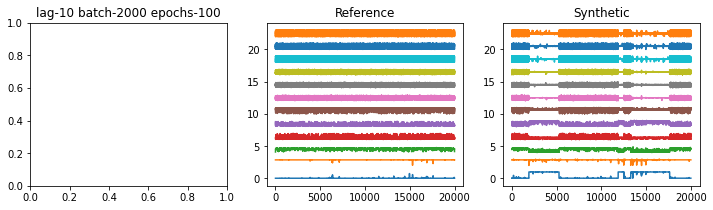

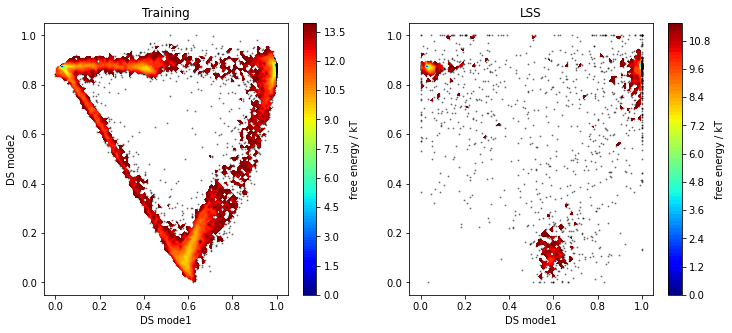

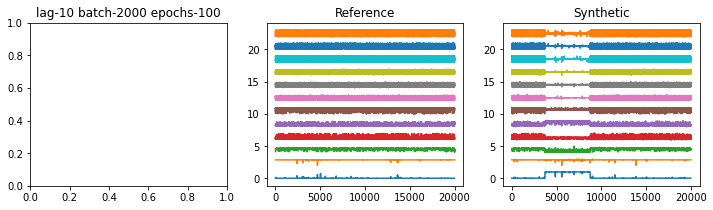

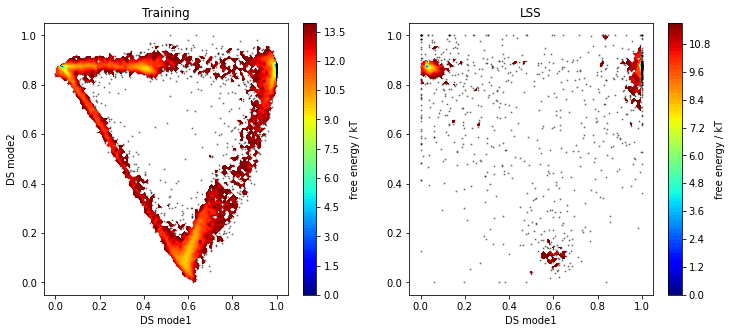

In [9]:
## load the props in loop and add molgen all in one step

# modes passed into each
ds_modes, s1_modes, s2_modes, pros_modes = [0,1], [0,1], [0,1], []
prop_modes = [ds_modes, s1_modes, s2_modes, pros_modes]

# number of atoms per system -- can pass this in from xyz
atoms_list = [64, 32, 32]

# params for loading data
dists_path = './trajs/aligned_trajs_mix/'
n_trajs = 10

# params for saving synthetic trajs
#save_synth = './trajs/synth_trajs/3-step_220711/'
n_synth_trajs = 10       #10
n_synth_frames = 20_000   #20000
#r_cut = 2.0 #nm  #1.0 doesn't capture fraying, 3.0 adds a minimum -- try 2.0?

# pre-trained components
load_dir = f'./save_LSS_components/'
srv_path = f'{load_dir}/srvs/srv_dim-3-3-3_lag-10_e-10_scaled-01'
prop_path = f'{load_dir}/props/T-320_trajs-10_eps-100_batch-100_mix-50'
molgen_path = f'{load_dir}/molgens/220525_b-5000_e-5000_s-10'

synth_list = []

# get rid of traj files to save space (just keep dists)
remove_trajs = True

'''
for conc in [200, 400]:

    # update with temp/conc
    save_synth = f'./trajs/synth_trajs/mix-longer-3-step_c-{conc}mM_eps-100-50_220803/'
    prop_path = f'{load_dir}/props/mix-c-{conc}_trajs-10_eps-100-50_batch-100_mix-50'
    
    # load features and + translational and rotational DoFs
    dist_file =  f'{dists_path}GCGG-T3_mix_{conc}mM_10-200001-231.npy'
    trans_file =  f'{dists_path}GCGG-T3_mix_{conc}mM_trans.npy'       
    angles_file = f'{dists_path}GCGG-T3_mix_{conc}mM_eulers.npy' 
'''

r_cut = 1.0
for temp in [320]:
    for order in [1,-1]:

        # update with temp/conc
        save_synth = f'./trajs/synth_trajs/mix-3-step_rcut-{r_cut}_ord-{order}_T-{temp}K_eps-{n_epochs_prop}-{n_epochs_dof}_220803/'
        prop_path = f'{load_dir}/props/mix-T-{temp}_trajs-10_eps-{n_epochs_prop}-{n_epochs_dof}_batch-100_mix-50_ord-{order}'

        # load features and + translational and rotational DoFs
        dist_file =  f'{dists_path}GCGG-T3_mix_{temp}K_10-200001-231.npy'
        trans_file =  f'{dists_path}GCGG-T3_mix_{temp}K_trans.npy'       
        angles_file = f'{dists_path}GCGG-T3_mix_{temp}K_eulers.npy'   

        # extract features for each system
        inter_dists  = np.load(dist_file)[:n_trajs, ::order, :121]
        intra1_dists = np.load(dist_file)[:n_trajs, ::order, 121:176]
        intra2_dists = np.load(dist_file)[:n_trajs, ::order, 176:231]
        pros_feats = np.concatenate((np.load(trans_file), np.load(angles_file)), axis=2)[:n_trajs, ::order]
        feats_list = [inter_dists, intra1_dists, intra2_dists, pros_feats]
        
        # instantiate lss by passing in all feats
        lss =  MULTI_LSS(feats_list, n_atoms=atoms_list[0])

        # load SRV
        lss.load_SRVs(srv_path)

        # load props from saved weights
        lss = load_props(lss, prop_path, prop_modes, n_mix=50, activation='relu')

        # load molgen
        lss = load_molgens(lss, molgen_path, prop_modes, atoms_list)

        # gen synthetic -- get rid or srv + pros outputs
        traj_inits = list(np.arange(n_synth_trajs))
        synth_trajs = lss.generate_synthetic(save_synth, n_synth_trajs, n_synth_frames, 
                                                 traj_idx=traj_inits, r_cutoff=r_cut)
        
        # calculate dists and remove unessecary trajs
        save_xyz_dists(save_synth)

        # calculate dists and remove unessecary trajs
        lss_coms = get_com_dists(save_synth, '*mix*xyz')

        # calculate com coordinates    
        if remove_trajs: 
            ! rm {save_synth}/*xyz

        # test prop kinetics
        lss.check_prop_kinetics()
        thermo_2d(lss.traj_prop_scaled, synth_trajs, idxs=[0, 1])

    ## train the temp/conc interpolation model with more data (try different normalization)


In [7]:
# load synth ord trajs and perform thermo + kinetics comparisons

com_for = np.load('./trajs/synth_trajs/mix-3-step_rcut-1.0_ord-1_T-320K_eps-100-1_220803/coms.npy')
com_rev = np.load('./trajs/synth_trajs/mix-3-step_rcut-1.0_ord--1_T-320K_eps-100-1_220803/coms.npy')

com_for = com_for.reshape(-1, 200_000)
com_rev = com_rev.reshape(-1, 200_000)

print(com_for.shape, com_rev.shape)

(3, 200000) (3, 200000)


Text(0.5, 0, 'Time (ns)')

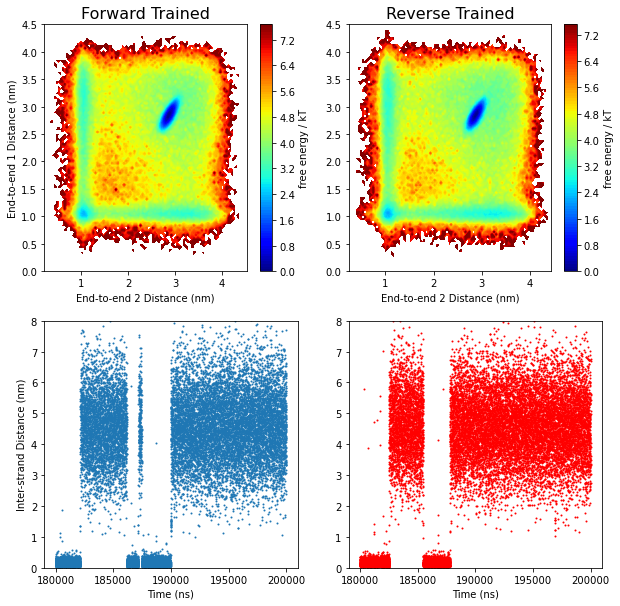

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

py.plots.plot_free_energy(com_for[1], com_for[2], ax=axes[0, 0], cmap='jet')
py.plots.plot_free_energy(com_rev[1], com_rev[2], ax=axes[0, 1], cmap='jet')

i = 9
pi, pf = i*20_000, (i+1)*20_000
x = np.arange(pi, pf)

axes[1, 0].scatter(x, com_for[0, pi:pf], s=1)
axes[1, 1].scatter(x, com_rev[0, pi:pf], s=1, c='red')

axes[1, 0].set_ylim(0, 8)
axes[1, 1].set_ylim(0, 8)
axes[0, 0].set_ylim(0, 4.5)
axes[0, 1].set_ylim(0, 4.5)

axes[0, 0].set_title('Forward Trained', fontsize=16)
axes[0, 1].set_title('Reverse Trained', fontsize=16)

axes[0, 0].set_ylabel('End-to-end 1 Distance (nm)')
axes[0, 0].set_xlabel('End-to-end 2 Distance (nm)')
axes[0, 1].set_xlabel('End-to-end 2 Distance (nm)')

axes[1, 0].set_ylabel('Inter-strand Distance (nm)')
axes[1, 0].set_xlabel('Time (ns)')
axes[1, 1].set_xlabel('Time (ns)')


In [12]:
# quantify this

print(np.sum(com_for[0] < 2.0) / len(com_for[0]))
print(np.sum(com_rev[0] < 2.0) / len(com_rev[0]))

0.289255
0.23651


In [ ]:
# modes passed into each
ds_modes, s1_modes, s2_modes, pros_modes = [0,1], [0,1], [0,1], []
prop_modes = [ds_modes, s1_modes, s2_modes, pros_modes]

# number of atoms per system -- can pass this in from xyz
atoms_list = [64, 32, 32]

# params for loading data
dists_path = './trajs/aligned_trajs_mix/'
n_trajs = 10

# params for saving synthetic trajs
#save_synth = './trajs/synth_trajs/3-step_220711/'
n_synth_trajs = 10       #10
n_synth_frames = 200_000   #20000
r_cut = 1.0 #nm

# pre-trained components
load_dir = f'./save_LSS_components/'
srv_path = f'{load_dir}/srvs/srv_dim-3-3-3_lag-10_e-10_scaled-01'
prop_path = f'{load_dir}/props/T-320_trajs-10_eps-100_batch-100_mix-50'
molgen_path = f'{load_dir}/molgens/220525_b-5000_e-5000_s-10'

synth_list = []

# get rid of traj files to save space (just keep dists)
remove_trajs = True

for conc in [200, 400]:

    # update with temp/conc
    save_synth = f'./trajs/synth_trajs/mix-3-step_longer-rcut-{r_cut}_c-{conc}mM_eps-100-50_220803/'
    prop_path = f'{load_dir}/props/mix-c-{conc}_trajs-10_eps-100-50_batch-100_mix-50'
    
    # load features and + translational and rotational DoFs
    dist_file =  f'{dists_path}GCGG-T3_mix_{conc}mM_10-200001-231.npy'
    trans_file =  f'{dists_path}GCGG-T3_mix_{conc}mM_trans.npy'       
    angles_file = f'{dists_path}GCGG-T3_mix_{conc}mM_eulers.npy'   

    # extract features for each system
    inter_dists  = np.load(dist_file)[:n_trajs, :, :121]
    intra1_dists = np.load(dist_file)[:n_trajs, :, 121:176]
    intra2_dists = np.load(dist_file)[:n_trajs, :, 176:231]
    pros_feats = np.concatenate((np.load(trans_file), np.load(angles_file)), axis=2)[:n_trajs]
    feats_list = [inter_dists, intra1_dists, intra2_dists, pros_feats]

    # instantiate lss by passing in all feats
    lss =  MULTI_LSS(feats_list, n_atoms=atoms_list[0])
    
    # load SRV
    lss.load_SRVs(srv_path)

    # load props from saved weights
    lss = load_props(lss, prop_path, prop_modes, n_mix=50, activation='relu')

    # load molgen
    lss = load_molgens(lss, molgen_path, prop_modes, atoms_list)

    # gen synthetic -- get rid or srv + pros outputs
    traj_inits = list(np.arange(n_synth_trajs))
    synth_trajs = lss.generate_synthetic(save_synth, n_synth_trajs, n_synth_frames, 
                                             traj_idx=traj_inits, r_cutoff=r_cut)
    
    # calculate dists
    save_xyz_dists(save_synth)
    
    # calculate com coordinates 
    get_com_dists(save_synth, '*mix*xyz')
    
    # remove xyzs to save space
    if remove_trajs: 
        ! rm {save_synth}/*xyz


(1, 9) (20000, 6)
(1, 12) (20000, 9)
(1, 20000, 12)
(200010, 2) (200000, 2)


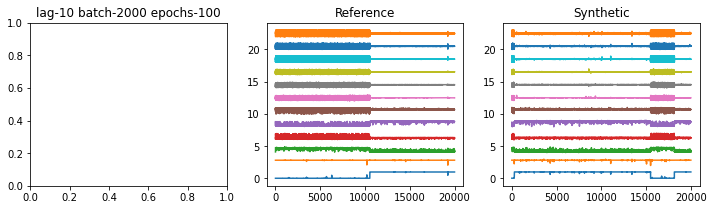

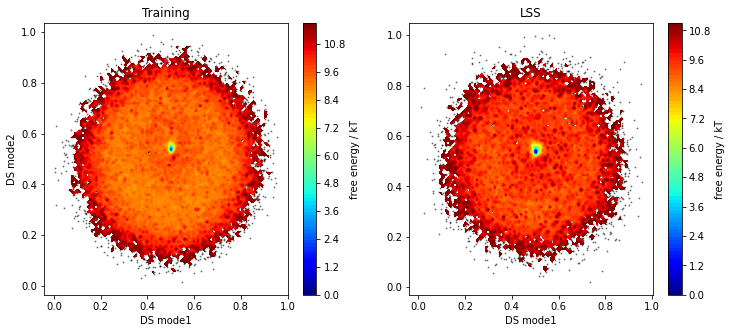

In [11]:
# test prop kinetics
lss.check_prop_kinetics()
thermo_2d([lss.traj_prop_scaled[i][::10] for i in range(10)], synth_trajs, idxs=[6,7])